In [7]:
# Kütüphaneler
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import json, codecs
import pandas as pd


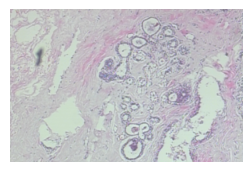

Görsel tensör boyutu: (460, 700, 3)


In [8]:
# Örnek görüntü yükleme
img = load_img(r"C:\Users\nisag\Desktop\klasor\BreaKHis_v1\histology_slides\breast\benign\SOB\adenosis\SOB_B_A_14-22549AB\40X\SOB_B_A-14-22549AB-40-001.png")

plt.figure(figsize=(3,3))
plt.imshow(img)
plt.axis("off")
plt.show()

x = img_to_array(img)
print("Görsel tensör boyutu:", x.shape)

In [9]:
# test ve train verilerini ayırmak için ImageDataGenerator kullandım
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    directory=r"C:\Users\nisag\Desktop\klasor\BreaKHis_v1\histology_slides\breast",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    subset="training",
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    directory=r"C:\Users\nisag\Desktop\klasor\BreaKHis_v1\histology_slides\breast",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    subset="validation",
    shuffle=False
)

Found 6328 images belonging to 2 classes.
Found 1581 images belonging to 2 classes.


In [10]:
# Model olarak DenseNet121 
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(1e-4), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,408 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 56, 56, 64)        │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 56, 56, 64)        │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 128)       │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 128)       │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 128)       │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 32)        │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 56, 56, 96)        │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 7,628,097 (29.10 MB)

 Trainable params: 590,593 (2.25 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [11]:
# Eğitim
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)

C:\Users\nisag\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 565s 3s/step - accuracy: 0.7209 - loss: 0.5557 - val_accuracy: 0.6863 - val_loss: 0.6138 - learning_rate: 1.0000e-04
Epoch 2/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 499s 3s/step - accuracy: 0.8094 - loss: 0.4226 - val_accuracy: 0.7236 - val_loss: 0.6678 - learning_rate: 1.0000e-04
Epoch 3/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 496s 3s/step - accuracy: 0.8511 - loss: 0.3605 - val_accuracy: 0.6970 - val_loss: 0.6670 - learning_rate: 1.0000e-04
Epoch 4/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 494s 2s/step - accuracy: 0.8673 - loss: 0.3288 - val_accuracy: 0.7179 - val_loss: 0.6493 - learning_rate: 1.0000e-04
Epoch 5/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 504s 3s/step - accuracy: 0.8777 - loss: 0.3082 - val_accuracy: 0.7268 - val_loss: 0.6708 - learning_rate: 5.0000e-05
Epoch 6/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 497s 3s/step - accuracy: 0.8801 - loss: 0.2986 - val_accuracy: 0.7388 - val_loss: 0.6457 - learning_rate: 5.0000e-05


In [12]:
# Modeli Kaydetme
model.save_weights("model_weights.weights.h5")

# Eğitim geçmişi kaydedildi
with codecs.open("history.json", "w", "utf-8") as f:
    json.dump(history.history, f)

pd.DataFrame(history.history).to_csv("history.csv", index=False)

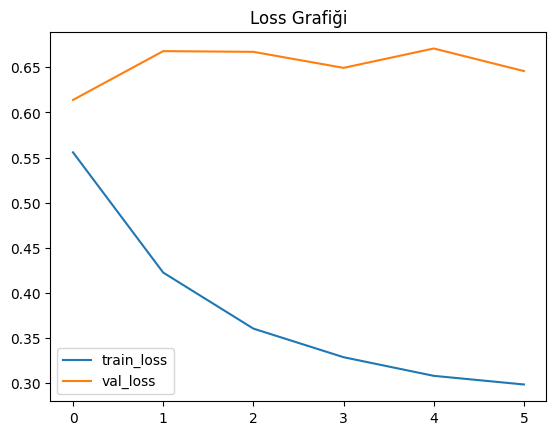

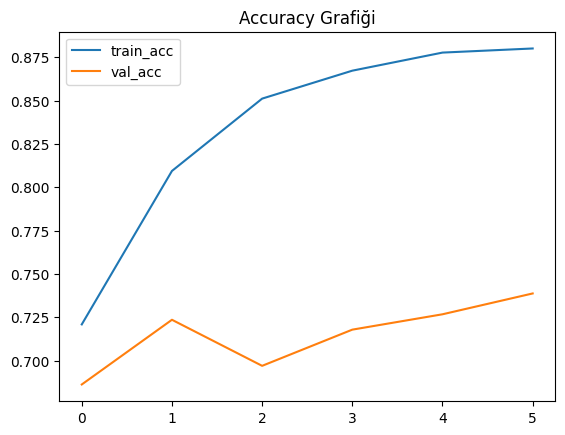

In [13]:
#  Eğitim Sonuçları (Grafikler)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss Grafiği")
plt.show()

plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend()
plt.title("Accuracy Grafiği")
plt.show()
